In [2]:
%tensorflow_version 2.x

# ACHTUNG! BERT does not work with tf 2.2.x-xx
!pip install -q tensorflow==2.0
!pip install -q tensorflow_hub
!pip install -q bert-for-tf2
!pip install -q sentencepiece


import tensorflow as tf
import tensorflow_hub as hub

# ACHTUNG! BERT does not work with tf 2.2.x-xx
tf.__version__

'2.0.0'

In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1845465677947154262, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 15912916885001707513
 physical_device_desc: "device: XLA_CPU device"]

# Imopts and tools

In [4]:
!pip install -q --no-deps git+https://www.github.com/nemoware/analyser.git@bert
!pip install -q git+https://github.com/tensorflow/docs

In [0]:
!pip install -q pyjarowinkler

In [6]:

from google.colab import drive

from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import pandas as pd
import os 
import bert
 
# from sklearn.metrics.pairwise import cosine_distances, cosine_similarity

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
from IPython.core.display import display, HTML
import PIL.Image
from tensorflow_docs import plots
from colab_support import renderer

from keras.layers import Conv1D, LSTM, Dense, Bidirectional, Input, Dropout
from keras.layers import MaxPooling1D
from keras.models import Model
from keras.utils import plot_model



import requests

from sklearn.cluster import * 

from tf_support.tools import KerasTrainingContext


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Nemoware Analyser v1.8.0
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
loading word cases stats model /usr/local/lib/python3.6/dist-packages/analyser/vocab/word_cases_stats.pickle


Using TensorFlow backend.


In [0]:
import warnings
def init_model(model_factory_fn, model_name_override=None, weights_file_override=None, verbose=0, trainable=True) -> Model:
  
  
  # registered_models[model_factory_fn.__name__] = model_factory_fn

  model_name = model_factory_fn.__name__
  if model_name_override is not None:
    model_name = model_name_override

  model = model_factory_fn( model_name  )
  model.name = model_name
  if verbose>1:
    model.summary()

  ch_fn = os.path.join(ctx.model_checkpoint_path, model_name+".weights")
  if weights_file_override is not None:
    ch_fn = path.join(ctx.model_checkpoint_path, weights_file_override+".weights")

  try:  
    model.load_weights (ch_fn)
  except:
    warnings.warn('cannot load '+  model_name+" from "+ ch_fn)
  
  if not trainable:
    model.trainable=False
    for l in model.layers:
      l.trainable=False

  return model



In [0]:
# plotter = plots.HistoryPlotter(smoothing_std=2)
 
def render_spectrum(x, h=100):   
  arr = (255 * ((x+1.0)*0.5).reshape((1,-1, 3))).astype(np.uint8)
  img = PIL.Image.fromarray(arr, 'RGB')
  img = img.resize( (1400,h), resample=PIL.Image.BICUBIC )
  display(img)

def render_token_colors(tokens, tcolors ) -> str:
  html = ''
  separator = ' '
  tcolors_scaled = ( tcolors + 1.0 ) * 0.5
  for d, word in enumerate(tokens):

    if word == ' ':
      word = '&nbsp; '
    
    token_color = colors.to_hex( tcolors_scaled[d] )
 
    html += f'<span style="background-color:{token_color}">{word}{separator}</span>'

    if tokens[d] == '\n':
      html += "¶<br>"

  return html
 

# Prepare BERT

In [0]:
max_seq_length = 1  # re-defined per batch ; TODO: del it

In [0]:
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/2", trainable=False)

#### Tokenizer

In [0]:
vocab_file =    bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()

tokenizer = bert.bert_tokenization.FullTokenizer(vocab_file, do_lower_case)

In [0]:

input_word_ids = layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")
input_mask = layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")
segment_ids = layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids")

pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

In [0]:
def get_masks(tokens, max_seq_length):
    """Mask for padding"""
    if len(tokens) > max_seq_length:
        raise IndexError("Token length more than max seq length!")
    return [1]*len(tokens) + [0] * (max_seq_length - len(tokens))


def get_segments(tokens, max_seq_length):
    """Segments: 0 for the first sequence, 1 for the second"""
    if len(tokens) > max_seq_length:
        raise IndexError("Token length more than max seq length!")
    segments = []
    current_segment_id = 0
    for token in tokens:
        segments.append(current_segment_id)
        if token == "[SEP]":
            current_segment_id = 1
    return segments + [0] * (max_seq_length - len(tokens))


# TODO: tokenizer??
def get_ids(tokens, tokenizer, max_seq_length):
    """Token ids from Tokenizer vocab"""
    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    input_ids = token_ids + [0] * (max_seq_length-len(token_ids))
    return input_ids


def get_max_len(tokenized_sentences):  
  max_seq_length = 0
  for ltokens in tokenized_sentences:   
    if len(ltokens) > max_seq_length:
      max_seq_length = len(ltokens)

  return  max_seq_length

def tokenize_sentences(sentences, tokenizer):
  stokens_=[]
 
  for line in sentences:
    ltokens = tokenizer.tokenize(line)
    ltokens = ["[CLS]"] + ltokens + ["[SEP]" ]
    stokens_.append(ltokens)

  return stokens_


def encode_tokens_for_embedding(tokenized_sentences, max_seq_length):
  
  input_ids_= [ get_ids(tt, tokenizer, max_seq_length) for tt in  tokenized_sentences] 
  input_masks_= [ get_masks(tt, max_seq_length) for tt in  tokenized_sentences] 
  input_segments_= [ get_segments(tt, max_seq_length) for tt in  tokenized_sentences] 

  return input_ids_, input_masks_, input_segments_
 

# Data

#### Mount drive

In [15]:

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
FRAG = 1200
data = pd.read_csv('/content/drive/My Drive/GazpromOil/Trips/export - Свод 2019.XLSX - Sheet1.csv')

data.drop_duplicates(subset ="Цель командировки", keep = False, inplace = True)
data = data.replace('1 - производственная', 0)
data = data.replace('2 - непроизводственная', 1)
print(data.info)
data.tail(10)

<bound method DataFrame.info of       Пункт назначения  ... Тип командировки
4                Тверь  ...                0
5              Белград  ...                0
8               Москва  ...                0
10              Москва  ...                0
11              Москва  ...                0
...                ...  ...              ...
12570           Москва  ...                0
12571           Москва  ...                0
12572           Москва  ...                0
12573           Москва  ...                0
12574           Москва  ...                0

[8477 rows x 3 columns]>


,Пункт назначения,Цель командировки,Тип командировки
12563,Белград,Участие в выездной сессии:«Операционная модель...,0
12564,"Лен. обл., Курортный район, Репино","Участие в выездной сессии Дирекции по добыче""П...",0
12565,Нови-Сад,"Участие в выездном совещании ""Операционная мод...",0
12566,"Лен. обл., Курортный район, Репино","Участие в совещании ""Подведение итогов работы ...",0
12568,Москва,"Участие в семинаре ""Энергетическая эффективнос...",0
12570,Москва,"Планирование деятельности ДВА ПАО ""Газпром неф...",0
12571,Москва,Участие в совещании по вопросам G-reporting в ...,0
12572,Москва,Участие в Форуме кадровых резервистов. Участие...,0
12573,Москва,"Участие в заседании Комитета по аудиту ПАО ""Га...",0
12574,Москва,"Участие в регулярном совещании ""Завтрак с руко...",0


The distribution is not balanced

In [17]:
data.describe()

,Тип командировки
count,8477.000000
mean,0.038221
std,0.191741
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [18]:
sentences = data['Цель командировки'].values[:FRAG]
print(sentences[:2])


tokenized_sentences = tokenize_sentences(sentences, tokenizer)
print(tokenized_sentences[0:2])

['1. Участие в совещании по проведению ПГИ на скважинах компании в 2019 году 2. Рассмотрение текущего состояния разработки месторождений'
 '1. Участие в Очной сесии №2 "ШельфПроджект - 3" 2. Рассмотрение текущего состояния разработки месторождений']
[['[CLS]', '1', '.', 'У', '##час', '##тие', 'в', 'сов', '##е', '##ща', '##нии', 'по', 'про', '##ведени', '##ю', 'П', '##Г', '##И', 'на', 'с', '##ква', '##жина', '##х', 'компании', 'в', '2019', 'году', '2', '.', 'Р', '##ас', '##с', '##мот', '##рение', 'тек', '##у', '##щего', 'состояния', 'разработки', 'место', '##ро', '##ж', '##дений', '[SEP]'], ['[CLS]', '1', '.', 'У', '##час', '##тие', 'в', 'О', '##чной', 'се', '##сии', '№', '##2', '"', 'Ш', '##ель', '##ф', '##П', '##род', '##же', '##кт', '-', '3', '"', '2', '.', 'Р', '##ас', '##с', '##мот', '##рение', 'тек', '##у', '##щего', 'состояния', 'разработки', 'место', '##ро', '##ж', '##дений', '[SEP]']]


### Embedding: 

```
max_seq_length= 88 sentences= 300
(300, 768)
CPU times: user 3min 9s, sys: 6.28 s, total: 3min 15s
Wall time: 1min 40s
```

In [19]:
%%time

def embedd_tokenized_sentences (tokenized_sentences):
  max_seq_length = get_max_len(tokenized_sentences)

  print('max_seq_length=', max_seq_length, 'sentences=', len(tokenized_sentences))
  input_ids_, input_masks_, input_segments_ = encode_tokens_for_embedding(tokenized_sentences, max_seq_length)


  input_word_ids = layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")
  input_mask =     layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")
  segment_ids =    layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids")

  pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])


  model = keras.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=[pooled_output, sequence_output])
  
  pool_embs, all_embs = model.predict([input_ids_, input_masks_, input_segments_])

  return pool_embs, all_embs

pool_embs, all_embs = embedd_tokenized_sentences (tokenized_sentences )

  
print(pool_embs.shape)

max_seq_length= 105 sentences= 1200
(1200, 768)
CPU times: user 16min, sys: 25.3 s, total: 16min 26s
Wall time: 8min 30s


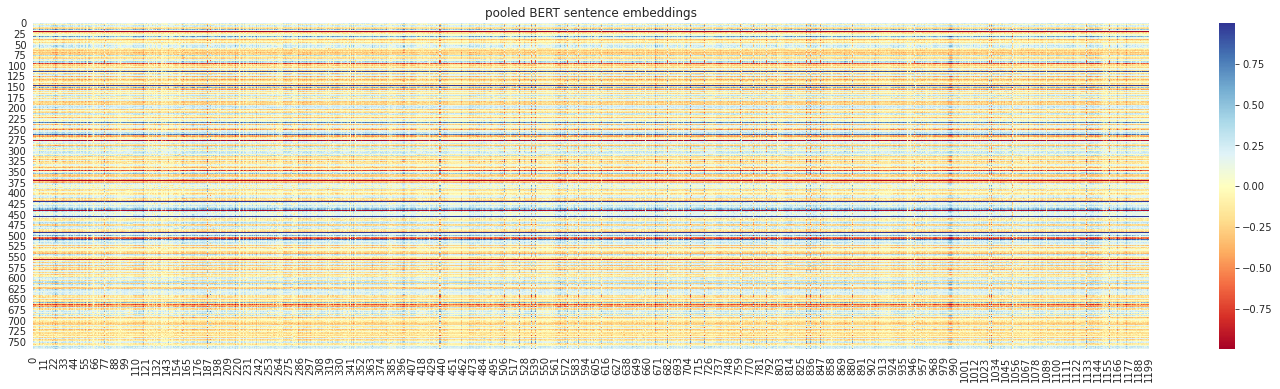

In [20]:
renderer.plot_embedding(pool_embs, title="pooled BERT sentence embeddings")

# Models

In [22]:
Y = data['Тип командировки'][:FRAG].values.T
X = all_embs
X.shape

(1200, 105, 768)

In [95]:
BATCH_SIZE = 40

np.random.seed(42)

indices = np.arange(0, X.shape[0])
np.random.shuffle(indices)

split_index = len(indices)//4


test_indices =  indices[:split_index]
train_indices =  indices[split_index:]


model_checkpoint_path = '/content/drive/My Drive/GazpromOil/Trips/'
ctx = KerasTrainingContext(model_checkpoint_path)
print(f'{len(test_indices)} vs {len(train_indices)}')


def save_stats(a, **kwargs):
  pass

ctx.save_stats=save_stats

ctx.set_batch_size_and_trainset_size(BATCH_SIZE, len(test_indices), len(train_indices))


300 vs 900


In [96]:
np.intersect1d(test_indices, train_indices )

array([], dtype=int64)

In [0]:

def make_generator( indices, batch_size=BATCH_SIZE, noisy_embeddings=True):
  
  np.random.seed(42)
  while True:

    batch_indices = np.random.choice(a=indices, size=batch_size)

    batch_input = []
    batch_output = []

    # Read in each input, perform preprocessing and get labels
    for i in batch_indices:
        
      batch_input.append( X[i] )
      batch_output.append( Y[i] )
   

    batch_x = np.array(batch_input)
    batch_y = np.array(batch_output)

    
    # Return a tuple of (input, output) to feed the network
    yield [batch_x, batch_y]
  
 


## Train

In [0]:
ctx.EPOCHS = 50

### 1 m1_trip_type_model_conv_bi_lstm_1
 

Model: "m1_trip_type_model_conv_bi_lstm_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_text_emb (InputLayer)  (None, None, 768)         0         
_________________________________________________________________
drops (Dropout)              (None, None, 768)         0         
_________________________________________________________________
conv1d_64 (Conv1D)           (None, None, 16)          98320     
_________________________________________________________________
max_pooling1d_64 (MaxPooling (None, None, 16)          0         
_________________________________________________________________
bidirectional_56 (Bidirectio (None, 16)                1600      
_________________________________________________________________
dense_64 (Dense)             (None, 2)                 34        
Total params: 99,954
Trainable params: 99,954
Non-trainable params: 0
_____________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: cannot load m1_trip_type_model_conv_bi_lstm_1 from /content/drive/My Drive/GazpromOil/Trips/m1_trip_type_model_conv_bi_lstm_1.weights


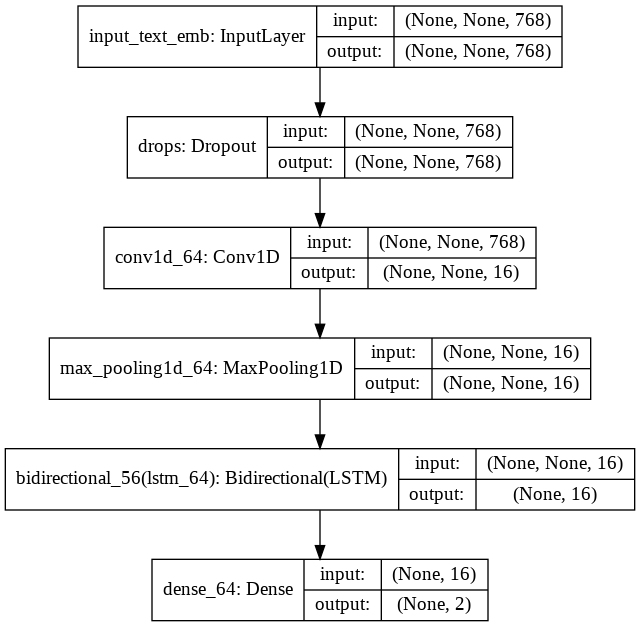

In [99]:
EMB=768
def m1_trip_type_model_conv_bi_lstm_1(name):
   
  CLASSES = 2
  
  input_text = Input(shape=[None, EMB], dtype='float32', name="input_text_emb")

  _out = input_text
  _out = Dropout(0.5, name="drops")(_out)
  _out = Conv1D(filters=16, kernel_size=(8), padding='same', activation='relu')(_out)
  _out = MaxPooling1D(pool_size=2)(_out)
  _out = Bidirectional(LSTM(8, return_sequences=False))(_out)
  _out = Dense(CLASSES, activation='softmax')(_out)

  model = Model(inputs=[input_text], outputs=_out, name=name)
  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model

 
model = init_model(m1_trip_type_model_conv_bi_lstm_1, verbose=2) 
plot_model(model, show_shapes=True)


In [0]:
# model.fit(  x= X ,  y= Y , epochs=20, validation_split=0.25, use_multiprocessing=True)
ctx.EVALUATE_ONLY = False
train_gen  = make_generator(train_indices, BATCH_SIZE)
test_gen  = make_generator(train_indices, BATCH_SIZE)
ctx.train_and_evaluate_model(model, generator=train_gen, test_generator=test_gen)

### 2 m2_trip_type_model_conv_bi_lstm_1_Nadam
 

Model: "m2_trip_type_model_conv_bi_lstm_1_Nadam"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_text_emb (InputLayer)  (None, None, 768)         0         
_________________________________________________________________
drops (Dropout)              (None, None, 768)         0         
_________________________________________________________________
conv1d_65 (Conv1D)           (None, None, 16)          98320     
_________________________________________________________________
max_pooling1d_65 (MaxPooling (None, None, 16)          0         
_________________________________________________________________
bidirectional_57 (Bidirectio (None, 16)                1600      
_________________________________________________________________
dense_65 (Dense)             (None, 2)                 34        
Total params: 99,954
Trainable params: 99,954
Non-trainable params: 0
_______________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: cannot load m2_trip_type_model_conv_bi_lstm_1_Nadam from /content/drive/My Drive/GazpromOil/Trips/m2_trip_type_model_conv_bi_lstm_1_Nadam.weights


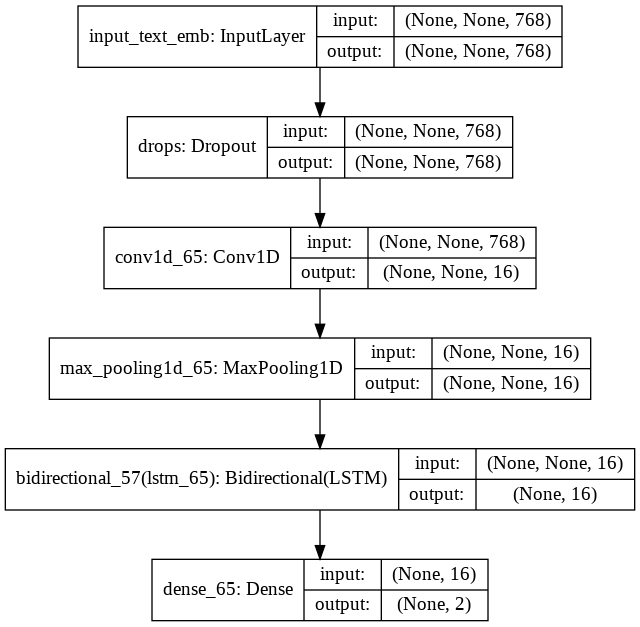

In [101]:
EMB=768
def m2_trip_type_model_conv_bi_lstm_1_Nadam(name):
   
  CLASSES = 2
  
  input_text = Input(shape=[None, EMB], dtype='float32', name="input_text_emb")

  _out = input_text
  _out = Dropout(0.5, name="drops")(_out)
  _out = Conv1D(filters=16, kernel_size=(8), padding='same', activation='relu')(_out)
  _out = MaxPooling1D(pool_size=2)(_out)
  _out = Bidirectional(LSTM(8, return_sequences=False))(_out)
  _out = Dense(CLASSES, activation='softmax')(_out)

  model = Model(inputs=[input_text], outputs=_out, name=name)
  model.compile(loss='sparse_categorical_crossentropy', optimizer='Nadam', metrics=['accuracy'])

  return model

 
model = init_model(m2_trip_type_model_conv_bi_lstm_1_Nadam, verbose=2) 
plot_model(model, show_shapes=True)


In [0]:
# model.fit(  x= X ,  y= Y , epochs=20, validation_split=0.25, use_multiprocessing=True)
ctx.EVALUATE_ONLY = False
train_gen  = make_generator(train_indices, BATCH_SIZE)
test_gen  = make_generator(train_indices, BATCH_SIZE)
ctx.train_and_evaluate_model(model, generator=train_gen, test_generator=test_gen)

### 3 m3_trip_type_model_conv_bi_lstm_tanh_2  TANH
 

Model: "m3_trip_type_model_conv_bi_lstm_tanh_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_text_emb (InputLayer)  (None, None, 768)         0         
_________________________________________________________________
drops (Dropout)              (None, None, 768)         0         
_________________________________________________________________
conv1d_66 (Conv1D)           (None, None, 20)          122900    
_________________________________________________________________
max_pooling1d_66 (MaxPooling (None, None, 20)          0         
_________________________________________________________________
drops_1 (Dropout)            (None, None, 20)          0         
_________________________________________________________________
bidirectional_58 (Bidirectio (None, 12)                1296      
_________________________________________________________________
drops_2 (Dropout)           

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: cannot load m3_trip_type_model_conv_bi_lstm_tanh_2 from /content/drive/My Drive/GazpromOil/Trips/m3_trip_type_model_conv_bi_lstm_tanh_2.weights


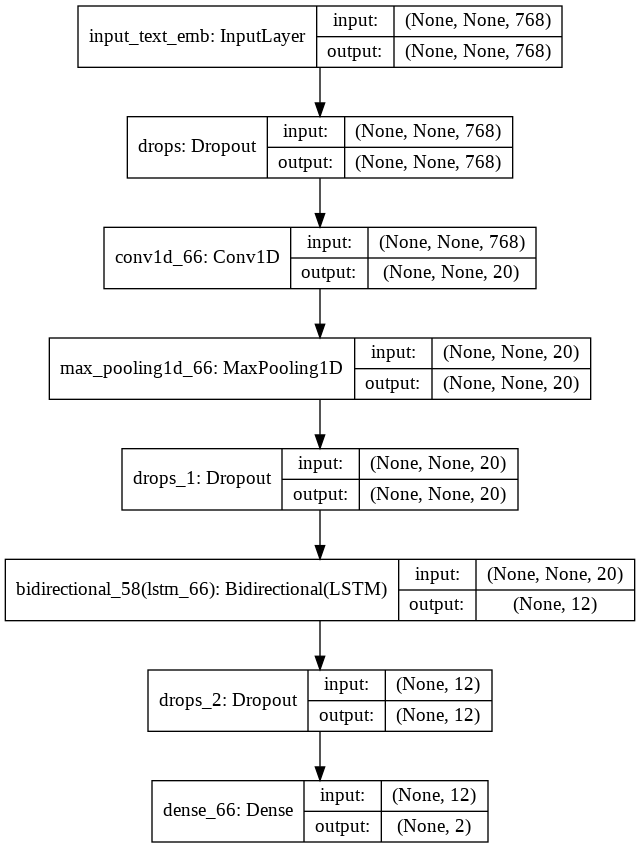

In [103]:
EMB=768
def m3_trip_type_model_conv_bi_lstm_tanh_2(name="new_model"):
   
  CLASSES = 2
  
  input_text = Input(shape=[None, EMB], dtype='float32', name="input_text_emb")

  _out = input_text
  _out = Dropout(0.45, name="drops")(_out)
  _out = Conv1D(filters=20, kernel_size=(8), padding='same', activation='tanh')(_out)
  _out = MaxPooling1D(pool_size=2)(_out)
  _out = Dropout(0.1, name="drops_1")(_out)
  _out = Bidirectional(LSTM(6, return_sequences=False))(_out)
  _out = Dropout(0.1, name="drops_2")(_out)
  _out = Dense(CLASSES, activation='softmax')(_out)

  model = Model(inputs=[input_text], outputs=_out, name=name)
  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model

 

model = init_model(m3_trip_type_model_conv_bi_lstm_tanh_2, verbose=2) 
plot_model(model, show_shapes=True)


In [0]:
ctx.EVALUATE_ONLY = False
train_gen  = make_generator(train_indices, BATCH_SIZE)
test_gen  = make_generator(train_indices, BATCH_SIZE)
ctx.train_and_evaluate_model(model, generator=train_gen, test_generator=test_gen)

### 4 m4_trip_type_model_conv_bi_lstm_relu_1_2

Model: "m4_trip_type_model_conv_bi_lstm_relu_1_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_text_emb (InputLayer)  (None, None, 768)         0         
_________________________________________________________________
drops (Dropout)              (None, None, 768)         0         
_________________________________________________________________
conv1d_67 (Conv1D)           (None, None, 20)          122900    
_________________________________________________________________
max_pooling1d_67 (MaxPooling (None, None, 20)          0         
_________________________________________________________________
drops_1 (Dropout)            (None, None, 20)          0         
_________________________________________________________________
bidirectional_59 (Bidirectio (None, 12)                1296      
_________________________________________________________________
drops_2 (Dropout)         

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: cannot load m4_trip_type_model_conv_bi_lstm_relu_1_2 from /content/drive/My Drive/GazpromOil/Trips/m4_trip_type_model_conv_bi_lstm_relu_1_2.weights


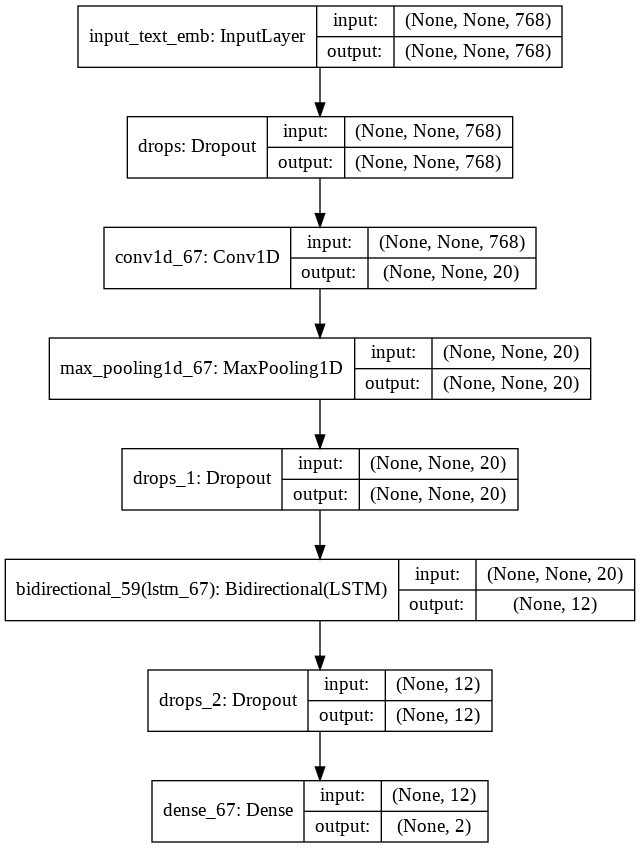

In [105]:


EMB=768
def m4_trip_type_model_conv_bi_lstm_relu_1_2(name="new_model"):
   
  CLASSES = 2
  
  input_text = Input(shape=[None, EMB], dtype='float32', name="input_text_emb")

  _out = input_text
  _out = Dropout(0.45, name="drops")(_out)
  _out = Conv1D(filters=20, kernel_size=(8), padding='same', activation='relu')(_out)
  _out = MaxPooling1D(pool_size=2)(_out)
  _out = Dropout(0.1, name="drops_1")(_out)
  _out = Bidirectional(LSTM(6, return_sequences=False))(_out)
  _out = Dropout(0.1, name="drops_2")(_out)
  _out = Dense(CLASSES, activation='softmax')(_out)

  model = Model(inputs=[input_text], outputs=_out, name=name)
  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model

model = init_model(m4_trip_type_model_conv_bi_lstm_relu_1_2, verbose=2) 
plot_model(model, show_shapes=True)



In [0]:
ctx.EVALUATE_ONLY = False
train_gen  = make_generator(train_indices, BATCH_SIZE)
test_gen  = make_generator(train_indices, BATCH_SIZE)
ctx.train_and_evaluate_model(model, generator=train_gen, test_generator=test_gen)

### 5 m5_trip_type_model_conv_bi_lstm_relu_2

Model: "m5_trip_type_model_conv_bi_lstm_relu_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_text_emb (InputLayer)  (None, None, 768)         0         
_________________________________________________________________
drops (Dropout)              (None, None, 768)         0         
_________________________________________________________________
conv1d_68 (Conv1D)           (None, None, 16)          98320     
_________________________________________________________________
max_pooling1d_68 (MaxPooling (None, None, 16)          0         
_________________________________________________________________
bidirectional_60 (Bidirectio (None, 32)                4224      
_________________________________________________________________
dense_68 (Dense)             (None, 2)                 66        
Total params: 102,610
Trainable params: 102,610
Non-trainable params: 0
______________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: cannot load m5_trip_type_model_conv_bi_lstm_relu_2 from /content/drive/My Drive/GazpromOil/Trips/m5_trip_type_model_conv_bi_lstm_relu_2.weights


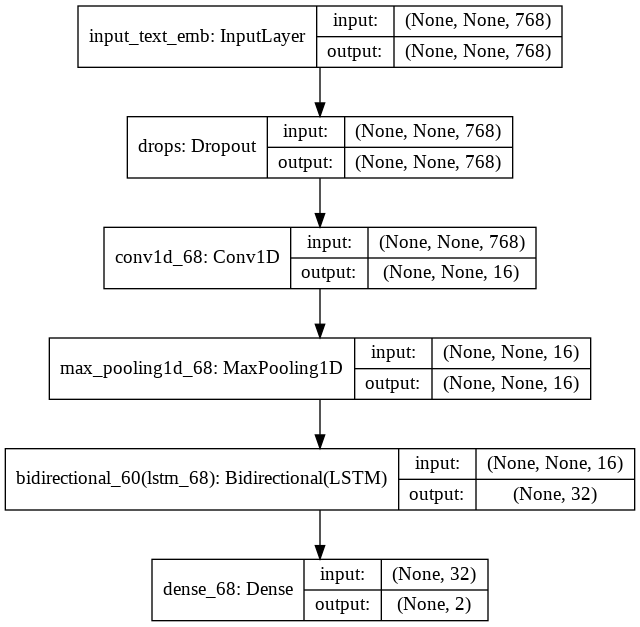

In [107]:
EMB=768
def m5_trip_type_model_conv_bi_lstm_relu_2(name="new_model"):
   
  CLASSES = 2
  
  input_text = Input(shape=[None, EMB], dtype='float32', name="input_text_emb")

  _out = input_text
  _out = Dropout(0.5, name="drops")(_out)
  _out = Conv1D(filters=16, kernel_size=(8), padding='same', activation='relu')(_out)
  _out = MaxPooling1D(pool_size=2)(_out)
  _out = Bidirectional(LSTM(16, return_sequences=False))(_out)
  _out = Dense(CLASSES, activation='softmax')(_out)

  model = Model(inputs=[input_text], outputs=_out, name=name)
  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model

 

model = init_model(m5_trip_type_model_conv_bi_lstm_relu_2, verbose=2) 
plot_model(model, show_shapes=True)

In [0]:
ctx.EVALUATE_ONLY = False
train_gen  = make_generator(train_indices, BATCH_SIZE)
test_gen  = make_generator(train_indices, BATCH_SIZE)
ctx.train_and_evaluate_model(model, generator=train_gen, test_generator=test_gen)

### 6 m6_trip_type_model_conv_bi_lstm_relu_2_Nadam
 

Model: "m6_trip_type_model_conv_bi_lstm_relu_2_Nadam"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_text_emb (InputLayer)  (None, None, 768)         0         
_________________________________________________________________
drops (Dropout)              (None, None, 768)         0         
_________________________________________________________________
conv1d_69 (Conv1D)           (None, None, 16)          98320     
_________________________________________________________________
max_pooling1d_69 (MaxPooling (None, None, 16)          0         
_________________________________________________________________
bidirectional_61 (Bidirectio (None, 32)                4224      
_________________________________________________________________
dense_69 (Dense)             (None, 2)                 66        
Total params: 102,610
Trainable params: 102,610
Non-trainable params: 0
________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: cannot load m6_trip_type_model_conv_bi_lstm_relu_2_Nadam from /content/drive/My Drive/GazpromOil/Trips/m6_trip_type_model_conv_bi_lstm_relu_2_Nadam.weights


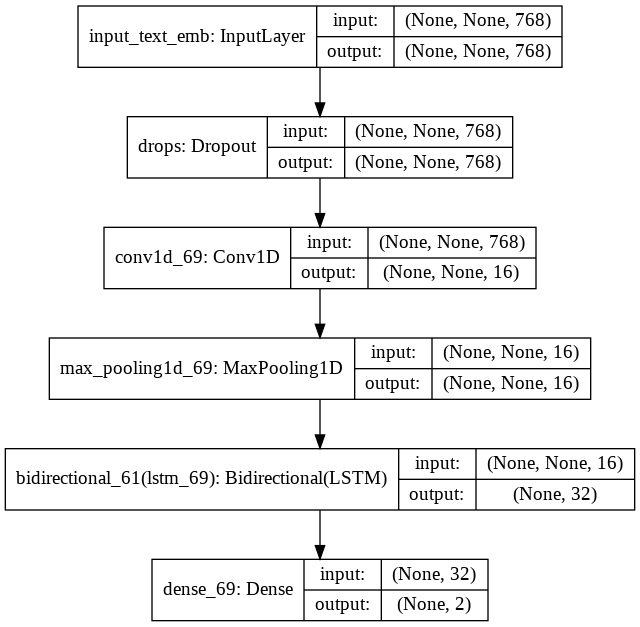

In [109]:
def m6_trip_type_model_conv_bi_lstm_relu_2_Nadam(name="new_model"):
   
  CLASSES = 2
  
  input_text = Input(shape=[None, EMB], dtype='float32', name="input_text_emb")

  _out = input_text
  _out = Dropout(0.5, name="drops")(_out)
  _out = Conv1D(filters=16, kernel_size=(8), padding='same', activation='relu')(_out)
  _out = MaxPooling1D(pool_size=2)(_out)
  _out = Bidirectional(LSTM(16, return_sequences=False))(_out)
  _out = Dense(CLASSES, activation='softmax')(_out)

  model = Model(inputs=[input_text], outputs=_out, name=name)
  model.compile(loss='sparse_categorical_crossentropy', optimizer='Nadam', metrics=['accuracy'])

  return model


model = init_model(m6_trip_type_model_conv_bi_lstm_relu_2_Nadam, verbose=2) 
plot_model(model, show_shapes=True)

In [0]:
ctx.EVALUATE_ONLY = False
train_gen  = make_generator(train_indices, BATCH_SIZE)
test_gen  = make_generator(train_indices, BATCH_SIZE)
ctx.train_and_evaluate_model(model, generator=train_gen, test_generator=test_gen)

### 7 👉🏿 m7_trip_type_model_conv_bi_lstm_relu_Nadam more drops

Model: "m7_trip_type_model_conv_bi_lstm_relu_Nadam"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_text_emb (InputLayer)  (None, None, 768)         0         
_________________________________________________________________
drops (Dropout)              (None, None, 768)         0         
_________________________________________________________________
conv1d_70 (Conv1D)           (None, None, 16)          98320     
_________________________________________________________________
drops_1 (Dropout)            (None, None, 16)          0         
_________________________________________________________________
max_pooling1d_70 (MaxPooling (None, None, 16)          0         
_________________________________________________________________
bidirectional_62 (Bidirectio (None, 32)                4224      
_________________________________________________________________
drops_2 (Dropout)       

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: cannot load m7_trip_type_model_conv_bi_lstm_relu_Nadam from /content/drive/My Drive/GazpromOil/Trips/m7_trip_type_model_conv_bi_lstm_relu_Nadam.weights


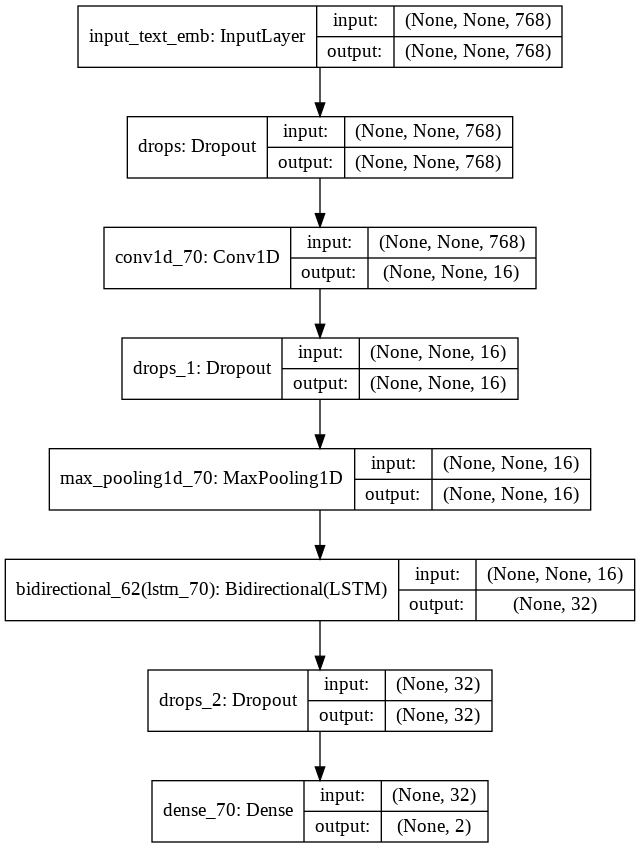

In [111]:

 
def m7_trip_type_model_conv_bi_lstm_relu_Nadam(name="new_model"):
   
  CLASSES = 2
  
  input_text = Input(shape=[None, EMB], dtype='float32', name="input_text_emb")

  _out = input_text
  _out = Dropout(0.5, name="drops")(_out)
  _out = Conv1D(filters=16, kernel_size=(8), padding='same', activation='relu')(_out)
  _out = Dropout(0.1, name="drops_1")(_out)
  _out = MaxPooling1D(pool_size=2)(_out)
  _out = Bidirectional(LSTM(16, return_sequences=False))(_out)
  _out = Dropout(0.1, name="drops_2")(_out)
  _out = Dense(CLASSES, activation='softmax')(_out)

  model = Model(inputs=[input_text], outputs=_out, name=name)
  model.compile(loss='sparse_categorical_crossentropy', optimizer='Nadam', metrics=['accuracy'])

  return model


model = init_model(m7_trip_type_model_conv_bi_lstm_relu_Nadam, verbose=2) 
plot_model(model, show_shapes=True)

In [0]:
ctx.EVALUATE_ONLY = False
train_gen  = make_generator(train_indices, BATCH_SIZE)
test_gen  = make_generator(train_indices, BATCH_SIZE)
ctx.train_and_evaluate_model(model, generator=train_gen, test_generator=test_gen)

### 8 m8_trip_type_model_conv_lstm_relu_3  

Model: "m8_trip_type_model_conv_lstm_relu_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_text_emb (InputLayer)  (None, None, 768)         0         
_________________________________________________________________
drops (Dropout)              (None, None, 768)         0         
_________________________________________________________________
conv1d_71 (Conv1D)           (None, None, 16)          98320     
_________________________________________________________________
drops_1 (Dropout)            (None, None, 16)          0         
_________________________________________________________________
max_pooling1d_71 (MaxPooling (None, None, 16)          0         
_________________________________________________________________
lstm_71 (LSTM)               (None, 16)                2112      
_________________________________________________________________
drops_2 (Dropout)            (N

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: cannot load m8_trip_type_model_conv_lstm_relu_3 from /content/drive/My Drive/GazpromOil/Trips/m8_trip_type_model_conv_lstm_relu_3.weights


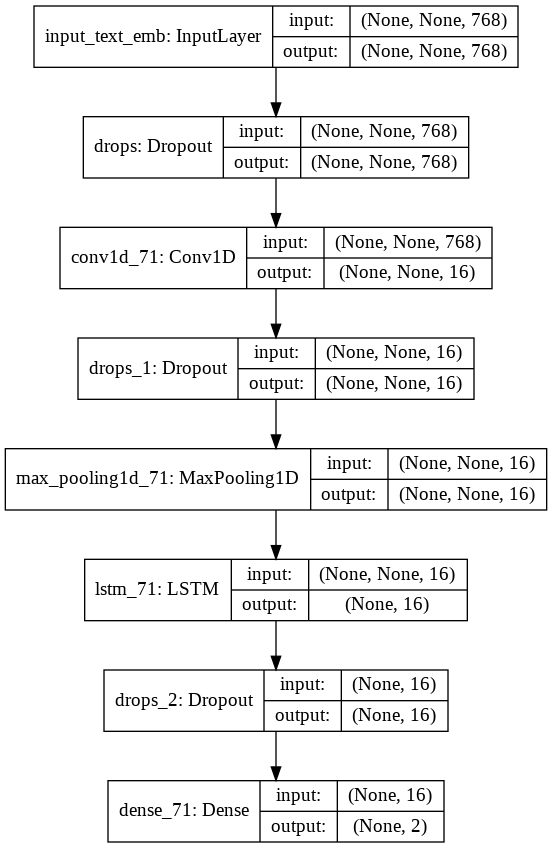

In [113]:
def m8_trip_type_model_conv_lstm_relu_3 (name="new_model"):
   
  CLASSES = 2
  
  input_text = Input(shape=[None, EMB], dtype='float32', name="input_text_emb")

  _out = input_text
  _out = Dropout(0.5, name="drops")(_out)
  _out = Conv1D(filters=16, kernel_size=(8), padding='same', activation='relu')(_out)
  _out = Dropout(0.1, name="drops_1")(_out)
  _out = MaxPooling1D(pool_size=2)(_out)
  _out = LSTM(16, return_sequences=False)(_out)
  _out = Dropout(0.1, name="drops_2")(_out)
  _out = Dense(CLASSES, activation='softmax')(_out)

  model = Model(inputs=[input_text], outputs=_out, name=name)
  model.compile(loss='sparse_categorical_crossentropy', optimizer='Nadam', metrics=['accuracy'])

  return model


model = init_model(m8_trip_type_model_conv_lstm_relu_3, verbose=2) 
plot_model(model, show_shapes=True)

In [114]:
ctx.EVALUATE_ONLY = False
train_gen  = make_generator(train_indices, BATCH_SIZE)
test_gen  = make_generator(train_indices, BATCH_SIZE)
ctx.train_and_evaluate_model(model, generator=train_gen, test_generator=test_gen)

model.name == m8_trip_type_model_conv_lstm_relu_3
log is not available /content/drive/My Drive/GazpromOil/Trips/m8_trip_type_model_conv_lstm_relu_3.log.csv
continue: lr:None, epoch:0
Epoch 1/50
12/12 [==============================] - 4s 315ms/step - loss: 0.2333 - accuracy: 0.9396 - val_loss: 0.0460 - val_accuracy: 0.9750

Epoch 00001: val_loss improved from inf to 0.04600, saving model to /content/drive/My Drive/GazpromOil/Trips/m8_trip_type_model_conv_lstm_relu_3.weights
Epoch 2/50
12/12 [==============================] - 3s 243ms/step - loss: 0.1026 - accuracy: 0.9750 - val_loss: 0.1783 - val_accuracy: 0.9656

Epoch 00002: val_loss did not improve from 0.04600
Epoch 3/50
12/12 [==============================] - 3s 243ms/step - loss: 0.1173 - accuracy: 0.9688 - val_loss: 0.0238 - val_accuracy: 0.9625

Epoch 00003: val_loss improved from 0.04600 to 0.02375, saving model to /content/drive/My Drive/GazpromOil/Trips/m8_trip_type_model_conv_lstm_relu_3.weights
Epoch 4/50
12/12 [=========

# Compare models

In [0]:
def get_log(model_name, log_path=ctx.model_checkpoint_path) -> pd.DataFrame:
  log_csv = os.path.join(log_path, model_name + '.log.csv')  
  return pd.read_csv(log_csv)
  
def plot_compare_models(models, metrics, title="metric/epoch"):
  colorstep = float(1.0 / len(models))
  # power = 3
  fig = plt.figure(figsize=(17, 6))
  ax = fig.gca()
  # ax.set_facecolor((0, 0, 0.1))

  for i, m in enumerate(models):
    data = get_log(m)
    data.set_index('epoch')
    for metric in metrics:

      key = "val_" + metric
      if key in data:
        x = data['epoch'][2:60]
        y = data[key][2:60]
        c = plt.cm.jet_r(i * colorstep)
        plt.plot(y, label=f'{m} {key}', alpha=0.2, color=c)
        y = y.rolling(4, win_type='gaussian').mean(std=4)

        plt.plot(y, label=f'{m} {key}', color=c)

    plt.legend()

  plt.title(title)
  plt.grid()
  plt.show()

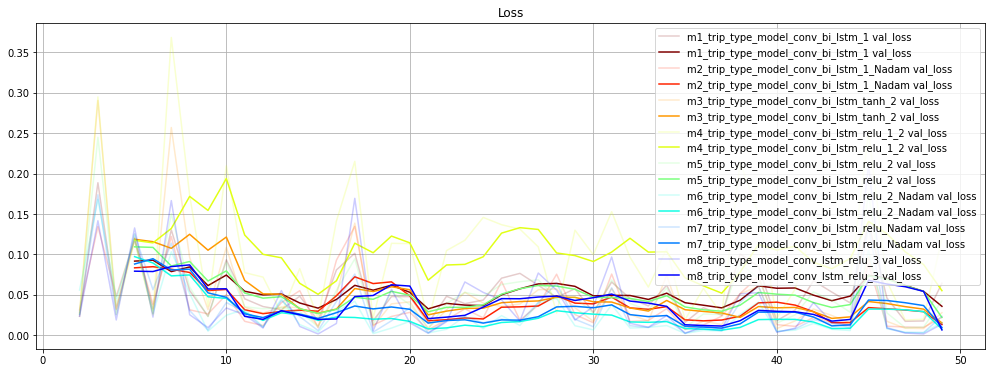

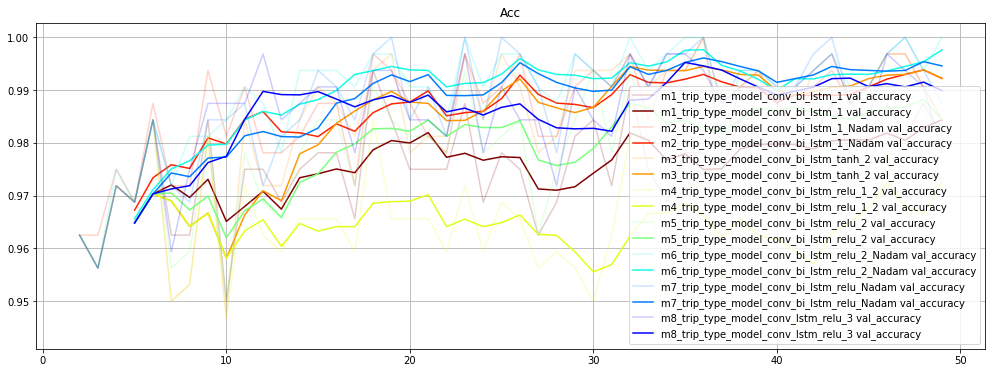

In [127]:
models = ['m1_trip_type_model_conv_bi_lstm_1',
          'm2_trip_type_model_conv_bi_lstm_1_Nadam', 
          'm3_trip_type_model_conv_bi_lstm_tanh_2', 
          'm4_trip_type_model_conv_bi_lstm_relu_1_2', 
          'm5_trip_type_model_conv_bi_lstm_relu_2',
          'm6_trip_type_model_conv_bi_lstm_relu_2_Nadam', 
          'm7_trip_type_model_conv_bi_lstm_relu_Nadam', 
          'm8_trip_type_model_conv_lstm_relu_3']
 


plot_compare_models(models, ['loss'], 'Loss')
plot_compare_models(models, ['accuracy'], 'Acc')

In [128]:
train_generator  = make_generator(train_indices, BATCH_SIZE)
test_generator  = make_generator(train_indices, BATCH_SIZE)
all_val_generator  = make_generator(indices, BATCH_SIZE)

 
_metric=0
ev = pd.DataFrame() 
gens = [all_val_generator, test_generator, train_generator]
 
for umodel_n in models:
  umodel = init_model(globals()[umodel_n], verbose=0) 
  print(f'eval {umodel.name}')
  subsets=['all', 'test', 'train']
  
  for i, _gen in enumerate(gens):
    evaluation = umodel.evaluate_generator(_gen, verbose=2, steps=16)
    print(umodel.metrics_names[_metric], evaluation[_metric])
 
     
    ev.at[ umodel.name , f"-{subsets[i]}-{umodel.metrics_names[_metric]}"] = evaluation[_metric]


sorted_ev = ev.sort_values('-test-loss')
sorted_ev

eval m1_trip_type_model_conv_bi_lstm_1
loss 0.03469131141901016
loss 0.03380777686834335
loss 0.03380777686834335
eval m2_trip_type_model_conv_bi_lstm_1_Nadam
loss 0.07500831037759781
loss 0.012909392826259136
loss 0.010724169202148914
eval m3_trip_type_model_conv_bi_lstm_tanh_2
loss 0.10867305099964142
loss 0.02163120172917843
loss 0.007339899893850088
eval m4_trip_type_model_conv_bi_lstm_relu_1_2
loss 0.05536715313792229
loss 0.16860434412956238
loss 0.09688851237297058
eval m5_trip_type_model_conv_bi_lstm_relu_2
loss 0.10072433948516846
loss 0.03867364674806595
loss 0.0861109122633934
eval m6_trip_type_model_conv_bi_lstm_relu_2_Nadam
loss 0.0017351508140563965
loss 0.20212797820568085
loss 0.04386919364333153
eval m7_trip_type_model_conv_bi_lstm_relu_Nadam
loss 0.008256925269961357
loss 0.010220229625701904
loss 0.014689430594444275
eval m8_trip_type_model_conv_lstm_relu_3
loss 0.0039897882379591465
loss 0.047395773231983185
loss 0.06996985524892807


,-all-loss,-test-loss,-train-loss
m7_trip_type_model_conv_bi_lstm_relu_Nadam,0.008257,0.010220,0.014689
m2_trip_type_model_conv_bi_lstm_1_Nadam,0.075008,0.012909,0.010724
m3_trip_type_model_conv_bi_lstm_tanh_2,0.108673,0.021631,0.007340
m1_trip_type_model_conv_bi_lstm_1,0.034691,0.033808,0.033808
m5_trip_type_model_conv_bi_lstm_relu_2,0.100724,0.038674,0.086111
m8_trip_type_model_conv_lstm_relu_3,0.003990,0.047396,0.069970
m4_trip_type_model_conv_bi_lstm_relu_1_2,0.055367,0.168604,0.096889
m6_trip_type_model_conv_bi_lstm_relu_2_Nadam,0.001735,0.202128,0.043869


In [131]:
sorted_ev = ev.sort_values('-test-loss')
sorted_ev

,-all-loss,-test-loss,-train-loss
m7_trip_type_model_conv_bi_lstm_relu_Nadam,0.008257,0.010220,0.014689
m2_trip_type_model_conv_bi_lstm_1_Nadam,0.075008,0.012909,0.010724
m3_trip_type_model_conv_bi_lstm_tanh_2,0.108673,0.021631,0.007340
m1_trip_type_model_conv_bi_lstm_1,0.034691,0.033808,0.033808
m5_trip_type_model_conv_bi_lstm_relu_2,0.100724,0.038674,0.086111
m8_trip_type_model_conv_lstm_relu_3,0.003990,0.047396,0.069970
m4_trip_type_model_conv_bi_lstm_relu_1_2,0.055367,0.168604,0.096889
m6_trip_type_model_conv_bi_lstm_relu_2_Nadam,0.001735,0.202128,0.043869


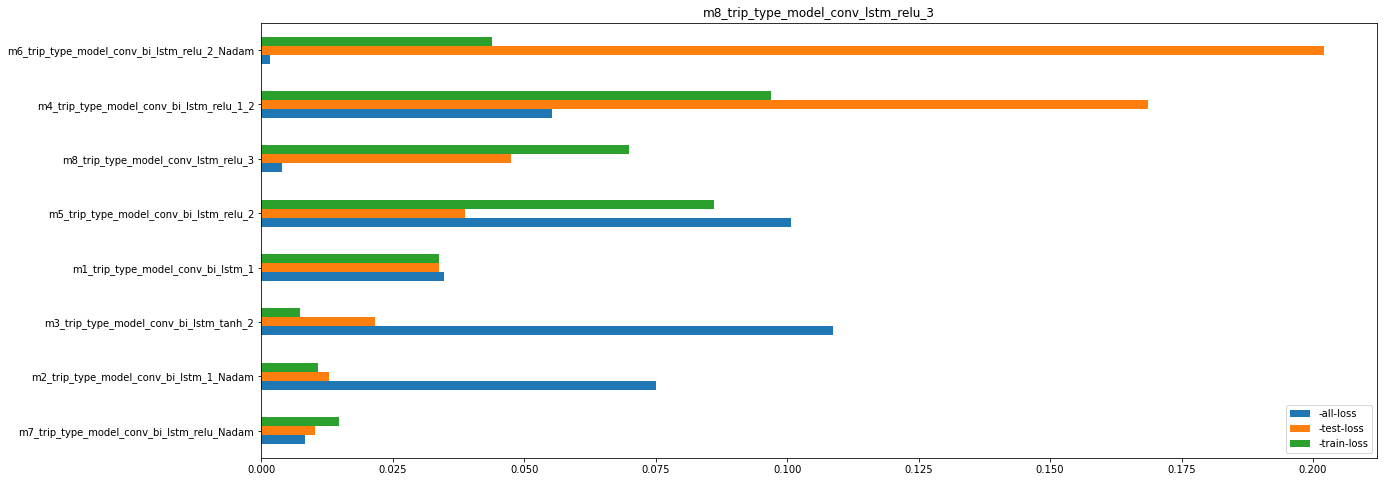

In [132]:
sorted_ev.plot(kind='barh', figsize=(20,8), title=f'{umodel.name}' )
plt.show()

# Winning BEST 3 models

best_models =                                             -all-loss  -test-loss  -train-loss
m7_trip_type_model_conv_bi_lstm_relu_Nadam   0.008257    0.010220     0.014689
m2_trip_type_model_conv_bi_lstm_1_Nadam      0.075008    0.012909     0.010724
m3_trip_type_model_conv_bi_lstm_tanh_2       0.108673    0.021631     0.007340


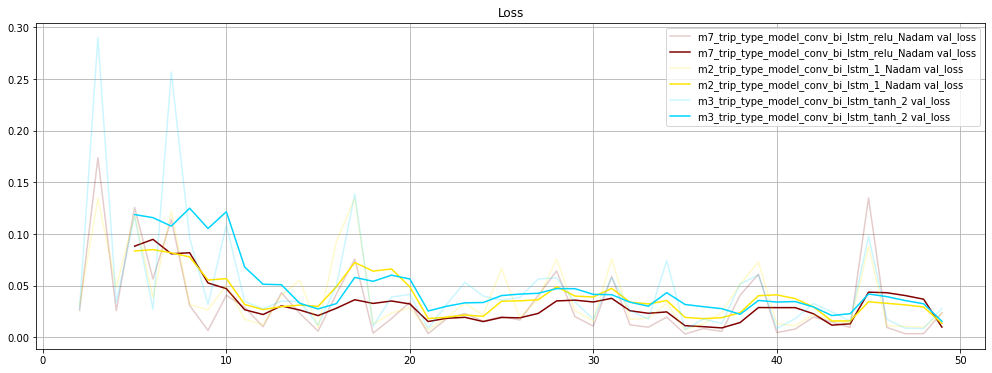

In [133]:
best_model_name = sorted_ev.iloc[0:3]
print('best_models =', best_model_name)
plot_compare_models(best_model_name.index.values, ['loss'], 'Loss')